# Hurricane Damage Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=1dcbc2ba-64f7-4eda-9309-990ec7a4578c
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 162MB/s]


In [3]:
!unzip -q hurricane_detector.zip

In [4]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 23 11:46 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 21 21:47 sample_data/
drwxr-xr-x 4 root root     4096 Jun 23 11:46 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 23 11:46 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (723 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently installe

In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.12.0


In [9]:
tf.keras.utils.set_random_seed(seed = 42)

## Utility functions to create dataset generators

In [10]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


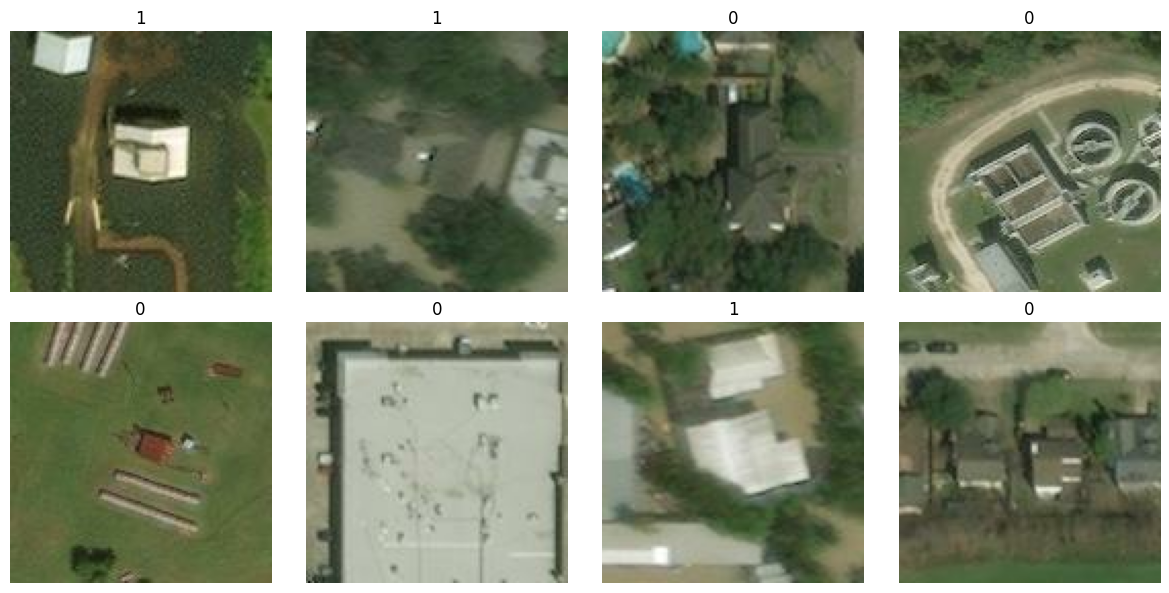

In [12]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

# Import libraries

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Experiment 1 - Basic CNN from scratch

This is the CNN architecture from the paper

**without**

* Data augmentation
* Dropout layer
* L2 Regularization

In [14]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
34/34 [==============================] - 15s 67ms/step - loss: 0.6573 - accuracy: 0.5787 - val_loss: 0.5802 - val_accuracy: 0.7159
Epoch 2/30
34/34 [==============================] - 1s 26ms/step - loss: 0.4753 - accuracy: 0.8068 - val_loss: 0.6552 - val_accuracy: 0.6384
Epoch 3/30
34/34 [==============================] - 1s 25ms/step - loss: 0.4017 - accuracy: 0.8270 - val_loss: 0.3390 - val_accuracy: 0.8930
Epoch 4/30
34/34 [==============================] - 1s 29ms/step - loss: 0.2548 - accuracy: 0.8905 - val_loss: 0.4297 - val_accuracy: 0.8413
Epoch 5/30
34/34 [==============================] - 2s 52ms/step - loss: 0.2521 - accuracy: 0.9034 - val_loss: 0.3041 - val_accuracy: 0.9004
Epoch 6/30
34/34 [==============================] - 1s 28ms/step - loss: 0.1847 - accuracy: 0.9319 - val_loss: 0.2751 - val_accuracy: 0.9041
Epoch 7/30
34/34 [==============================] - 1s 24ms/step - loss: 0.1636 - accuracy: 0.9319 - val_loss: 0.2555 - val_accuracy: 0.9114
Epoch 8/30
3

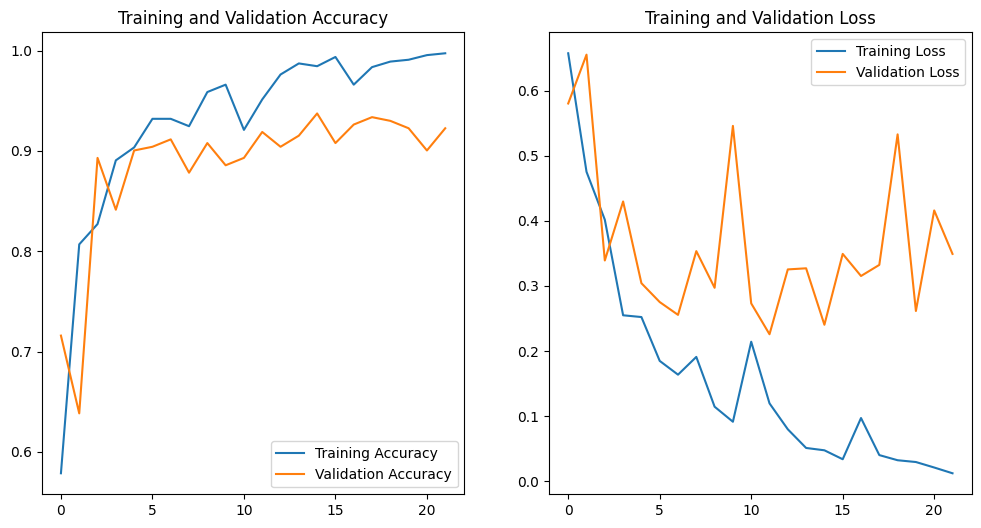

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
y_true, y_pred = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:53,  1.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:31,  2.94it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:24,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:20,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:18,  4.81it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:18,  4.92it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:26,  3.33it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:24,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:23,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:22,  3.80it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:22,  3.81it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:20,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:20,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:20,  4.08it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:18,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:04<00:16,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:04<00:15,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:14,  5.42it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:04<00:13,  5.73it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:12,  6.01it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:12,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:11,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:05<00:12,  6.04it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:05<00:11,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:11,  6.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:10,  6.51it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:10,  6.49it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:10,  6.25it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:06<00:10,  6.21it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:06<00:10,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:10,  5.98it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:10,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:10,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:09,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:07<00:09,  6.53it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:07<00:09,  6.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:07<00:09,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:07<00:09,  6.30it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:08,  6.43it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:08,  6.51it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:08,  6.38it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:08<00:08,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:08<00:08,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:08<00:08,  6.44it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:08<00:07,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:07,  6.39it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.43it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:09<00:07,  6.63it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:09<00:07,  6.61it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:09<00:07,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:09<00:07,  6.42it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:06,  6.49it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.33it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:10<00:06,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:10<00:06,  6.33it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:10<00:06,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:05,  6.45it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:05,  6.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.31it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:11<00:05,  6.29it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:11<00:05,  6.12it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:11<00:05,  6.13it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:05,  6.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:05,  6.15it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:05,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:12<00:04,  6.06it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:12<00:04,  6.10it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:04,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:04,  6.44it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:03,  6.33it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.44it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:13<00:03,  6.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:13<00:03,  6.71it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:02,  6.74it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:02,  6.73it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.43it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:14<00:03,  5.00it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:14<00:03,  4.76it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:15<00:02,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:15<00:02,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:15<00:02,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:15<00:01,  4.91it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:16<00:01,  5.07it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:16<00:01,  5.33it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:16<00:00,  5.64it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:16<00:00,  5.97it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:16<00:00,  6.51it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:16<00:00,  6.81it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:16<00:00,  7.16it/s]

3/3 [==============================] - 0s 96ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


In [20]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [21]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.94      0.85      0.89      6333
      damage       0.85      0.94      0.89      5895

    accuracy                           0.89     12228
   macro avg       0.90      0.90      0.89     12228
weighted avg       0.90      0.89      0.89     12228



,0,1
0,5390,943
1,357,5538


# Experiment 2 - Basic CNN from scratch
# + Data augmentation

This is the CNN architecture from the paper

**adding their**

* Data augmentation
  * random rotation
  * horizontal flip
  * (vertical and horizontal shift) --> RandomTranslation
  * (shear) --> not sure how to do it
  * zoom
  * added contrast --> not in the original paper

**without**

* Dropout layer
* L2 Regularization

In [32]:
data_augmentation = tf.keras.Sequential([
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
            layers.experimental.preprocessing.RandomRotation(0.2),
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
            layers.experimental.preprocessing.RandomZoom(0.2),
            #layers.experimental.preprocessing.RandomContrast(0.2)
        ])

In [33]:
model = Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [34]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)      

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [36]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
34/34 [==============================] - 6s 33ms/step - loss: 0.7332 - accuracy: 0.5345 - val_loss: 0.6743 - val_accuracy: 0.5498
Epoch 2/30
34/34 [==============================] - 1s 27ms/step - loss: 0.6818 - accuracy: 0.5851 - val_loss: 0.6973 - val_accuracy: 0.4576
Epoch 3/30
34/34 [==============================] - 1s 27ms/step - loss: 0.6909 - accuracy: 0.5253 - val_loss: 0.6606 - val_accuracy: 0.7196
Epoch 4/30
34/34 [==============================] - 1s 34ms/step - loss: 0.6117 - accuracy: 0.6863 - val_loss: 0.5300 - val_accuracy: 0.7749
Epoch 5/30
34/34 [==============================] - 1s 40ms/step - loss: 0.5424 - accuracy: 0.7534 - val_loss: 0.5220 - val_accuracy: 0.7786
Epoch 6/30
34/34 [==============================] - 1s 28ms/step - loss: 0.5662 - accuracy: 0.7185 - val_loss: 0.4930 - val_accuracy: 0.7970
Epoch 7/30
34/34 [==============================] - 1s 27ms/step - loss: 0.5019 - accuracy: 0.7636 - val_loss: 0.5187 - val_accuracy: 0.7417
Epoch 8/30
34

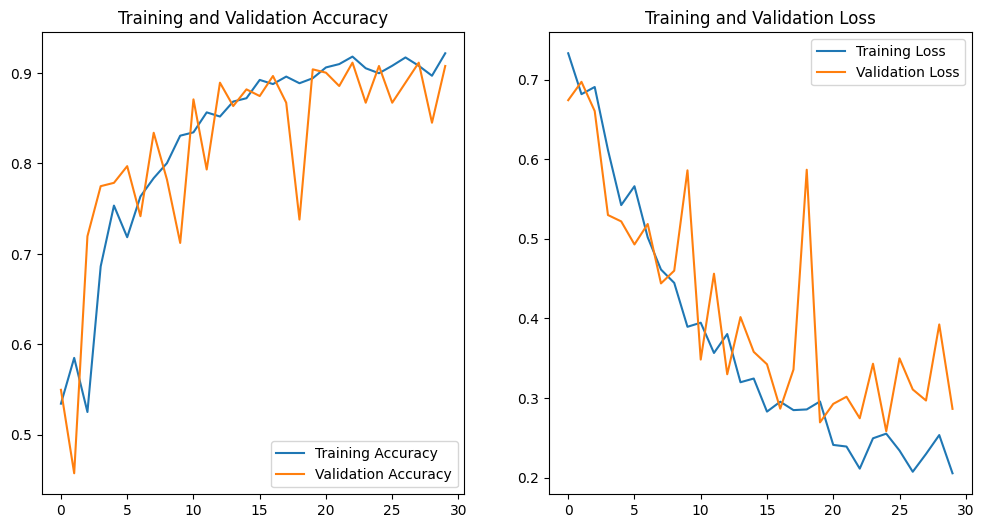

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
y_true, y_pred = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:48,  1.97it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:28,  3.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:20,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:18,  4.97it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:16,  5.38it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:15,  5.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:14,  6.02it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:14,  6.14it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:13,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:12,  6.62it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:12,  6.63it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:11,  6.84it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:12,  6.60it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:12,  6.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:02<00:12,  6.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:12,  6.24it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:12,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:12,  6.24it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:03<00:11,  6.55it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:03<00:11,  6.31it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:03<00:11,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.38it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:11,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:11,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:04<00:10,  6.27it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:04<00:10,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:04<00:10,  6.31it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:11,  5.76it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:12,  5.25it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:13,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:13,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:05<00:12,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:13,  4.54it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:13,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:13,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:12,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:12,  4.49it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:12,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:11,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:10,  5.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:09,  5.55it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:08,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:08<00:08,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:08,  6.15it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.22it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:07,  6.38it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:07,  6.14it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:07,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:09<00:07,  6.37it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:06,  6.64it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.64it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.42it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  6.27it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  6.43it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:06,  6.45it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:05,  6.68it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:05,  6.75it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.42it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  6.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:05,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:10<00:05,  6.28it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:04,  6.42it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:04,  6.42it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:04,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.08it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:11<00:04,  6.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:11<00:03,  6.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:03,  6.75it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.55it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:12<00:03,  6.07it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:12<00:03,  6.44it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:02,  6.62it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  6.30it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  6.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:02,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:13<00:02,  6.41it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:01,  6.51it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:01,  6.65it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:01,  6.73it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:14<00:01,  6.91it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:14<00:01,  7.15it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:14<00:01,  7.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:14<00:00,  7.08it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:14<00:00,  7.19it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.05it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:15<00:00,  6.96it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:15<00:00,  7.11it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:15<00:00,  7.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:15<00:00,  7.22it/s]

3/3 [==============================] - 0s 7ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:15<00:00,  6.05it/s]


In [39]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [40]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.86      0.96      0.91      6333
      damage       0.95      0.83      0.89      5895

    accuracy                           0.90     12228
   macro avg       0.90      0.89      0.90     12228
weighted avg       0.90      0.90      0.90     12228



,0,1
0,6070,263
1,995,4900


# Experiment 3 - Basic CNN from scratch
# + Data augmentation
# + Dropout layer
# + L2 Regularization

This is the CNN architecture from the paper

**adding their**

* Data augmentation
  * random rotation
  * horizontal flip
  * (vertical and horizontal shift) --> RandomTranslation
  * (shear) --> not sure how to do it
  * zoom
  * added contrast --> not in the original paper
* Dropout layer
  * Droput of 50% before dense layers --> 50% in paper
* L2 Regularization
  * L2 regularization with lambda = 10^-6 --> same in paper

In [41]:
data_augmentation = tf.keras.Sequential([
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
            layers.experimental.preprocessing.RandomRotation(0.2),
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
            layers.experimental.preprocessing.RandomZoom(0.2),
        ])

In [42]:
model = Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(10e-6)),
  layers.Dense(1, activation='sigmoid')
])

In [43]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 128)      

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
            )

In [45]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 10,
                                                  restore_best_weights = True)

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/30
34/34 [==============================] - 4s 31ms/step - loss: 0.7027 - accuracy: 0.5299 - val_loss: 0.6816 - val_accuracy: 0.5461
Epoch 2/30
34/34 [==============================] - 1s 26ms/step - loss: 0.6520 - accuracy: 0.6127 - val_loss: 0.5791 - val_accuracy: 0.7306
Epoch 3/30
34/34 [==============================] - 1s 29ms/step - loss: 0.6964 - accuracy: 0.5695 - val_loss: 0.6552 - val_accuracy: 0.7786
Epoch 4/30
34/34 [==============================] - 1s 38ms/step - loss: 0.6703 - accuracy: 0.6099 - val_loss: 0.7118 - val_accuracy: 0.4576
Epoch 5/30
34/34 [==============================] - 1s 29ms/step - loss: 0.7032 - accuracy: 0.4885 - val_loss: 0.7033 - val_accuracy: 0.4576
Epoch 6/30
34/34 [==============================] - 1s 26ms/step - loss: 0.6908 - accuracy: 0.5465 - val_loss: 0.6760 - val_accuracy: 0.5683
Epoch 7/30
34/34 [==============================] - 1s 27ms/step - loss: 0.6506 - accuracy: 0.6329 - val_loss: 0.5780 - val_accuracy: 0.7934
Epoch 8/30
34

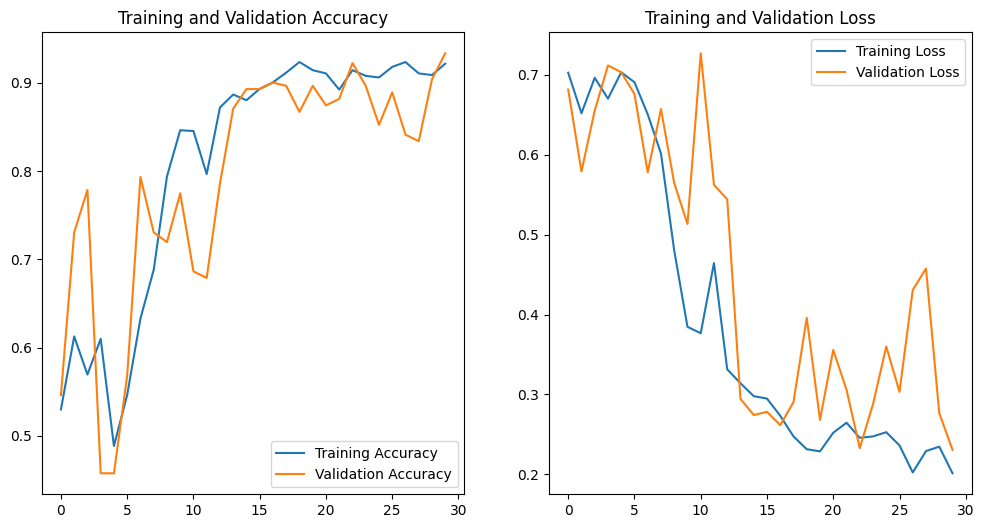

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
y_true, y_pred = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:45,  2.07it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:28,  3.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:22,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:18,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:17,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:16,  5.54it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:14,  6.03it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.04it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:14,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:13,  6.43it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:12,  6.57it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.23it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:12,  6.48it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:12,  6.34it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:12,  6.53it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:12,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:02<00:11,  6.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:12,  6.38it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:12,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:11,  6.50it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:03<00:11,  6.30it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:03<00:11,  6.57it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:03<00:11,  6.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:12,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:11,  6.19it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:11,  6.24it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:04<00:10,  6.28it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:04<00:11,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:04<00:10,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:10,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:10,  6.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:10,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:10,  5.93it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:05<00:10,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:05<00:09,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.28it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:09,  6.21it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:09,  6.07it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:06<00:09,  6.29it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:06<00:09,  6.05it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:06<00:09,  5.98it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:08,  6.28it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:08,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:08,  6.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:08,  6.28it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:07<00:08,  6.04it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:07<00:08,  5.49it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:08,  5.39it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:09,  4.89it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:09,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:09,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:09,  4.61it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:09,  4.42it/s]

4/4 [==============================] - 0s 13ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:09,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:09,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:08,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:10<00:08,  4.65it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:07,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:06,  5.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:06,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:05,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:11<00:05,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:05,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:05,  6.07it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:04,  6.10it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.10it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.34it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:04,  5.90it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:04,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:04,  6.15it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:04,  5.95it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  5.90it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:13<00:03,  6.21it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:03,  6.48it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:02,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.44it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  6.49it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:02,  6.30it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  6.37it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:01,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:01,  6.38it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:01,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:14<00:01,  6.71it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:14<00:01,  7.08it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:14<00:01,  7.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:00,  7.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:00,  7.23it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:15<00:00,  7.30it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:15<00:00,  7.52it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:15<00:00,  7.55it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:15<00:00,  7.69it/s]

3/3 [==============================] - 0s 7ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:16<00:00,  5.96it/s]


In [48]:
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

In [49]:
print(classification_report(y_true, y_pred,
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   no_damage       0.92      0.92      0.92      6333
      damage       0.91      0.92      0.91      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228



,0,1
0,5819,514
1,497,5398
